In [1]:
# Import common libraries
import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint
import os

# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Import MNE-NIRS processing
import mne
from mne_nirs.channels import get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects


# Based on Guides Published Here
# https://mne.tools/mne-nirs/stable/auto_examples/general/plot_16_waveform_group.html

In [2]:
def individual_analysis(bids_path):

    # Read data with annotations in BIDS format
    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, verbose=True, preload=False)
    raw_intensity = get_long_channels(raw_intensity, min_dist=0.01)
    
    channel_types = raw_intensity
    print(channel_types)
    
    raw_intensity.annotations.rename({'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'})

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth= 0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    # raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(0.8)
    raw_od = temporal_derivative_distribution_repair(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo = raw_haemo.filter(0.02, 0.3,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)

    events, event_dict = events_from_annotations(raw_haemo, verbose=False)

    # Remove the END triggers to hardcode the duration (30 seconds)
    events = events[::2]


    # NEED TO LOOK INTO SHORTEST AND LONGEST EVENTS TO ENSRUE TMIN AND TMAX ARE ACCURATE
    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-1.0, tmax= 15,
                    reject=dict(hbo=200e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=0,
                    preload=True, verbose=False)
    print(epochs)

    return raw_haemo, epochs

In [3]:
all_evokeds = defaultdict(list)

subjects = os.listdir("../BIDS_Direct/")
for sub in subjects:
    if sub != ".DS_Store":
        # Create path to file based on experiment info
        f_path = f'../BIDS_Direct/{sub}/nirs/{sub}_task-AnonCom_nirs.snirf'
        
        # Analyse data and return both ROI and channel results
        raw_haemo, epochs = individual_analysis(f_path)
        
        # Save individual-evoked participant data along with others in all_evokeds
        for cidx, condition in enumerate(epochs.event_id):
            print(condition)
            all_evokeds[condition].append(epochs[condition].average())
            
# pprint(all_evokeds)

Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Direct/sub-01/nirs/sub-01_task-AnonCom_nirs.snirf
<RawSNIRF | sub-01_task-AnonCom_nirs.snirf, 36 x 17098 (1680.6 s), ~4.9 MB, data loaded>
<Epochs |  12 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~206 kB, data loaded,
 'Control': 3
 'Inflammatory': 3
 'Neutral': 3
 'Practice': 3>
Control
Inflammatory
Neutral
Practice
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Direct/sub-02/nirs/sub-02_task-AnonCom_nirs.snirf
<RawSNIRF | sub-02_task-AnonCom_nirs.snirf, 36 x 14804 (1455.1 s), ~4.2 MB, data loaded>
<Epochs |  12 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~206 kB, data loaded,
 'Control': 3
 'Inflammatory': 3
 'Neutral': 3
 'Practice': 3>
Control
Inflammatory
Neutral
Practice
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Direct/sub-0

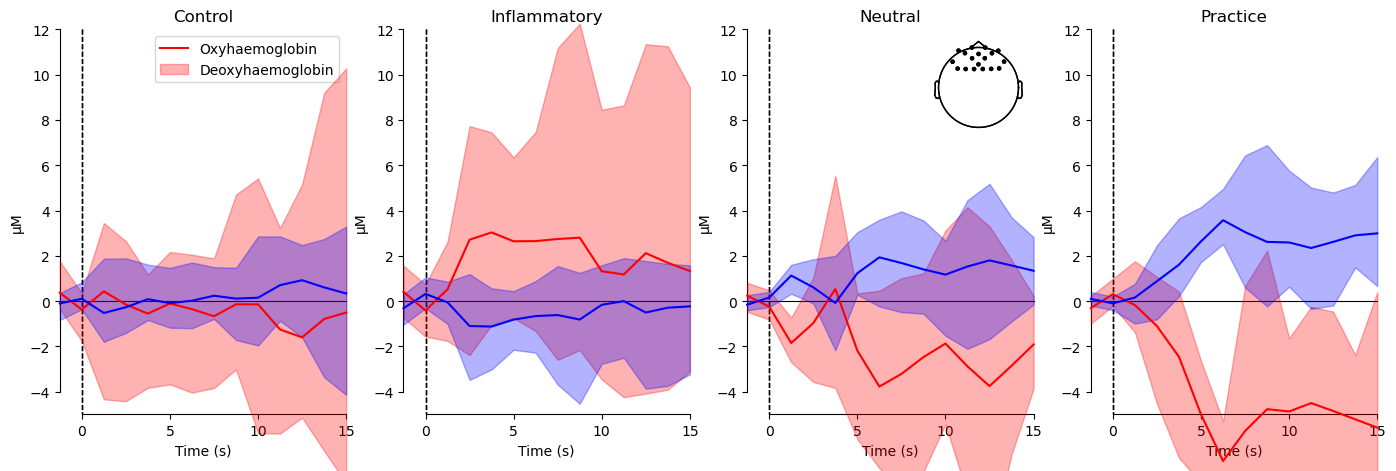

In [4]:
# Print figures

# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 12], hbr=[-5, 12])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds):
        plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                             picks=pick, axes=axes[idx], show=False,
                             colors=[color], legend=False, ylim=lims, ci=0.95,
                             show_sensors=idx == 2)
        axes[idx].set_title('{}'.format(evoked))
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

In [5]:
# Extract Evoked Amplitude

df = pd.DataFrame(columns=['ID', 'Chroma', 'Condition', 'Value'])

for idx, evoked in enumerate(all_evokeds):
    subj_id = 0
    for subj_data in all_evokeds[evoked]:
        subj_id += 1
        for chroma in ["hbo", "hbr"]:
            data = deepcopy(subj_data)
            value = data.crop(tmin=-1.0, tmax=15.0).data.mean() * 1.0e6

            # Append metadata and extracted feature to dataframe
            this_df = pd.DataFrame(
                {'ID': subj_id, 'Chroma': chroma,
                 'Condition': evoked, 'Value': value}, index=[0])
            df = pd.concat([df, this_df], ignore_index=True)
df.reset_index(inplace=True, drop=True)
df['Value'] = pd.to_numeric(df['Value'])  # some Pandas have this as object

# You can export the dataframe for analysis in your favorite stats program
df.to_csv("stats-export.csv")

# Print out the first entries in the dataframe
# df

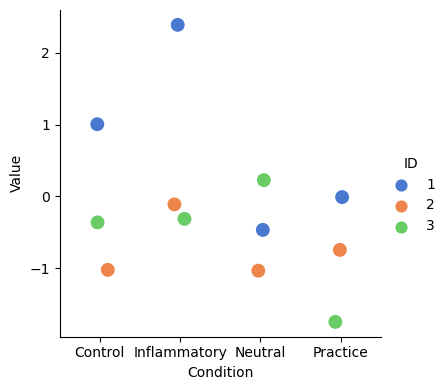

In [6]:
# Plot the Data
sns.catplot(x="Condition", y="Value", hue="ID", data=df.query("Chroma == 'hbo'"), ci=None, palette="muted", height=4, s=10)


In [7]:
# Inflammatory vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Neutral', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM    Dependent Variable:    Value  
No. Observations:     6          Method:                REML   
No. Groups:           3          Scale:                 1.3350 
Min. group size:      2          Log-Likelihood:        -7.3523
Max. group size:      2          Converged:             Yes    
Mean group size:      2.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.656    0.667  0.983 0.325 -0.651  1.964
Condition[T.Neutral] -1.081    0.943 -1.146 0.252 -2.930  0.768
Group Var             0.000    0.905                           
===============================================================

"""

In [8]:
df.query("Condition in ['Neutral']").query("Chroma in ['hbo']").mean()

/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_39497/1319272879.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.query("Condition in ['Neutral']").query("Chroma in ['hbo']").mean()


ID       2.000000
Value   -0.424722
dtype: float64

In [9]:
# Control vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Control', 'Neutral']")
input_data = input_data.query("Chroma in ['hbo']")
# print(input_data)
model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM    Dependent Variable:    Value  
No. Observations:     6          Method:                REML   
No. Groups:           3          Scale:                 0.5627 
Min. group size:      2          Log-Likelihood:        -6.1041
Max. group size:      2          Converged:             Yes    
Mean group size:      2.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.126    0.495 -0.255 0.799 -1.097  0.845
Condition[T.Neutral] -0.299    0.612 -0.487 0.626 -1.499  0.902
Group Var             0.173    0.857                           
===============================================================

"""

In [10]:
# Control vs Inflammatory Prompt Analysis

input_data = df.query("Condition in ['Control', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                 MixedLM      Dependent Variable:      Value  
No. Observations:      6            Method:                  REML   
No. Groups:            3            Scale:                   0.2296 
Min. group size:       2            Log-Likelihood:          -6.4386
Max. group size:       2            Converged:               Yes    
Mean group size:       2.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 -0.126    0.746 -0.169 0.866 -1.589  1.337
Condition[T.Inflammatory]  0.782    0.391  1.999 0.046  0.015  1.549
Group Var                  1.442    4.594                           
====================================================================

"""

In [11]:
# Practice vs Inflammatory Prompt Analysis

input_data = df.query("Condition in ['Practice', 'Inflammatory']")

input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    Value  
No. Observations:      6          Method:                REML   
No. Groups:            3          Scale:                 0.3914 
Min. group size:       2          Log-Likelihood:        -6.8075
Max. group size:       2          Converged:             Yes    
Mean group size:       2.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.656    0.711  0.923 0.356 -0.737  2.049
Condition[T.Practice] -1.491    0.511 -2.918 0.004 -2.492 -0.489
Group Var              1.125    2.985                           
================================================================

"""

In [12]:
# Practice vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Neutral', 'Practice']")
input_data = input_data.query("Chroma in ['hbo']")
print(input_data)
model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

   ID Chroma Condition     Value
12  1    hbo   Neutral -0.466488
14  2    hbo   Neutral -1.035030
16  3    hbo   Neutral  0.227352
18  1    hbo  Practice -0.009547
20  2    hbo  Practice -0.745357
22  3    hbo  Practice -1.748780


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    Value  
No. Observations:      6          Method:                REML   
No. Groups:            3          Scale:                 0.5810 
Min. group size:       2          Log-Likelihood:        -5.6882
Max. group size:       2          Converged:             Yes    
Mean group size:       2.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             -0.425    0.440 -0.965 0.334 -1.287  0.438
Condition[T.Practice] -0.410    0.622 -0.659 0.510 -1.630  0.810
Group Var              0.000                                    
================================================================

"""

In [13]:
# Practice vs Control Prompt Analysis

input_data = df.query("Condition in ['Control', 'Practice']")
input_data = input_data.query("Chroma in ['hbo']")
print(input_data)
model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

   ID Chroma Condition     Value
0   1    hbo   Control  1.006849
2   2    hbo   Control -1.023419
4   3    hbo   Control -0.361924
18  1    hbo  Practice -0.009547
20  2    hbo  Practice -0.745357
22  3    hbo  Practice -1.748780


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    Value  
No. Observations:      6          Method:                REML   
No. Groups:            3          Scale:                 0.3821 
Min. group size:       2          Log-Likelihood:        -6.1854
Max. group size:       2          Converged:             Yes    
Mean group size:       2.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             -0.126    0.553 -0.228 0.820 -1.210  0.958
Condition[T.Practice] -0.708    0.505 -1.404 0.160 -1.698  0.281
Group Var              0.535    1.661                           
================================================================

"""

In [23]:
# Mixed linear model not accounting for difference in hbo and hbr
# df
model = smf.mixedlm("Value ~ Condition", df, groups=df["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                  MixedLM     Dependent Variable:     Value   
No. Observations:       24          Method:                 REML    
No. Groups:             3           Scale:                  0.4381  
Min. group size:        8           Log-Likelihood:         -26.1562
Max. group size:        8           Converged:              Yes     
Mean group size:        8.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 -0.126    0.516 -0.245 0.807 -1.137  0.884
Condition[T.Inflammatory]  0.782    0.382  2.047 0.041  0.033  1.531
Condition[T.Neutral]      -0.299    0.382 -0.781 0.435 -1.048  0.450
Condition[T.Practice]     -0.708    0.382 -1.854 0.064 -1.457  0.041
Group Var                  0.578    1.008                           
====================================================================

"""